# 训练一个图像分类器¶
依次按照下列顺序进行：

使用torchvision加载和归一化CIFAR10训练集和测试集

定义一个卷积神经网络

定义损失函数

在训练集上训练网络

在测试集上测试网络

读取和归一化 CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [5]:
# 数据加载和处理
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


horse  bird  frog  frog


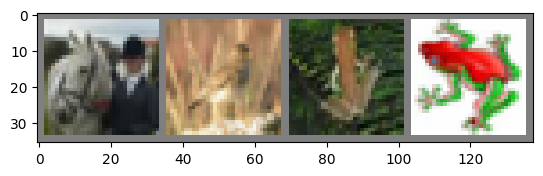

In [7]:
# 查看图像
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

#展示图像
imshow(torchvision.utils.make_grid(images))
# 显示图像标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
# 定义网络
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [8]:
# 定义损失函数和优化器
# 我们使用交叉熵作为损失函数，使用带动量的随机梯度下降。
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
# 训练网络
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印状态信息
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.204
[1,  4000] loss: 1.866
[1,  6000] loss: 1.678
[1,  8000] loss: 1.577
[1, 10000] loss: 1.498
[1, 12000] loss: 1.461
[2,  2000] loss: 1.385
[2,  4000] loss: 1.347
[2,  6000] loss: 1.349
[2,  8000] loss: 1.321
[2, 10000] loss: 1.298
[2, 12000] loss: 1.296
Finished Training


GroundTruth:    cat  ship  ship plane


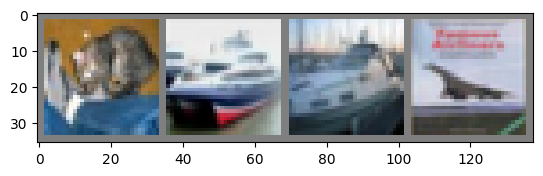

In [10]:
# 在测试集上测试网络
# 我们在整个训练集上进行了2次训练，但是我们需要检查网络是否从数据集中学习到有用的东西。 通过预测神经网络输出的类别标签与实际情况标签进行对比来进行检测。 如果预测正确，我们把该样本添加到正确预测列表。 第一步，显示测试集中的图片并熟悉图片内容。

dataiter = iter(testloader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
# 使用网络来识别上面网络
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [12]:
# 网络在整个测试集上的结果如何。
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [19]:
# 识别哪一个类的时候好，哪一个不好呢？
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 52 %
Accuracy of   car : 65 %
Accuracy of  bird : 27 %
Accuracy of   cat : 35 %
Accuracy of  deer : 31 %
Accuracy of   dog : 59 %
Accuracy of  frog : 72 %
Accuracy of horse : 63 %
Accuracy of  ship : 71 %
Accuracy of truck : 67 %


In [16]:
predicted = torch.tensor([[1, 2], [3, 4]])
labels = torch.tensor([[1, 2], [2, 4]])
c = (predicted == labels)
c.squeeze()

tensor([[ True,  True],
        [False,  True]])